<a href="https://colab.research.google.com/github/Kinds-of-Intelligence-CFI/measurement-layout-tutorial/blob/main/tutorial-notebooks/3_IntroductionToMeasurementLayouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now we will see how to implement the measurement layouts framework in PyMC. In this tutorial, for simplicity, we will use a synthetic dataset, but in later sessions we will work with real AI systems.

This synthetic dataset will mimic a navigation task. An agent will be situated in an arena and will need to find and navigate to a reward. In each instance the meta-features that can change will be the distance from the agent's start point and the reward, as well as the size of the reward. We will chiefly be interested in two capabilities that we will call Navigation and Vision.


To start with, let's download the dataset that we will be analyzing. We will also set up a few imports and functions that will be useful later on.




In [10]:
import pymc as pm
import numpy as np
import arviz as az
import random as rm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import graphviz

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.2


In [11]:
def logistic(x):
  return 1 / (1 + np.exp(-x))

def scaledBeta(name, a, b, min, max):

  beta = pm.Beta(f"{name}_raw", a, b)
  return pm.Deterministic(name, beta * (max - min) + min)

In [12]:
df = pd.read_csv("https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/measurement-layout-tutorial/main/data/visionNavigationMeasurementLayoutData.csv")

In [13]:
df.describe()

,Distance,Size,Success
count,50000.000000,50000.000000,50000.000000
mean,55.125597,5.073203,0.313120
std,26.046538,2.861179,0.463767
min,10.001372,0.100147,0.000000
25%,32.598002,2.594501,0.000000
50%,55.219270,5.084563,0.000000
75%,77.668348,7.550321,1.000000
max,99.998072,9.999556,1.000000


As you can see, we have a dataframe of 10000 task instances. For each of these instances we have the distance and size of reward as well as the success of a particular agent we wish to evaluate.
Using df.describe() we can see that this agent succeeds in nearly 32% of instances.
We can also see that in this dataset the distances range from 10-100 units, and range from 0.1 to 10 size units.

# A simple Measurement Layout

Let's create a simple measurement layout where the two meta-features, distance and size affect the agent's performance. We will assume that the task requires capabilities in both navigation and vision to succeed at the task. That is, navigation and vision are non-complementary. An agent cannot reach a far away reward with high vision capability if it does not also have an high navigation capability.


Before we start implementing our model in PyMC, we need to determine the meta-features, capabilities, and linknig functions as we wish to express them in the Measurement Layouts framework.

Clearly there are going to be two meta-features, corresponding to distance and size. And two capabilities, corresponding to navigation and vision.
There will be two partial performance node, again, for navigation and vision. And finally there will be the observed performance.

The most important parts to specify are the linking functions. How does partial performance depend on capabilities and meta-features?

In this model we will make the assumption that navigation performance depends simply on how far away the reward is. That is, on the margin of navigation ability and distance:
$$navigationP = \sigma(navigationAbility - instanceDistance)$$
The greater navigationAbility is relative to the instanceDistance, the more likely the agent is to succeed on the navigation aspect of the task. When the two are equal, a probability of success of 0.5 is yielded.

Vision, on the other hand, is a bit more complicated. Let us assume that the difficulty in identifying the object comes from its apparent size. Rather than depending on just size or distance, this depends on both.


We know from physics that a good approximation for the relation looks like:
$$ \text{apparent size} ∝ \frac{\text{size}}{\text{distance}} $$

So as the object gets further away, it linearly looks smaller, and as the size increases it linearly looks bigger.

We want some kind of equation mapping to
$$  \sigma  (lr - \frac{size}{distance}) $$

$lr$ here corresponds to some kind of "latent resolution" with which the agent can effectively identify objects.

However, note that $\frac{size}{distance}$ will get smaller as the task gets harder. In general we want to be consistent with bigger, positive margins corresponding with more success, so we will change the equation to:
$$   \sigma(acuity - \frac{distance}{size}) $$

Let's reframe $\frac{1}{lr}$ as $acuity$ to ensure that larger values for abilities correspond to better performance

Also note that we will be dealing with a ratio between 0 and $\infty$, but for small sizes / distances this might get close to zero, and floating point numbers are awkward. We also need the range to be $(-\infty, \infty)$ to allow the sigmoid to give a problability in $[0,1]$.

So we will reformulate to
\begin{align*}
& visualP= \sigma(log(acuity) - log(\frac{distance}{size})) \\
\end{align*}






Now having an acuity ability of $x$ allows the agent to identify  objects where  $\frac{distance}{size} < x$ with a probability of 0.5. Thus having a better acuity is better.

Finally, we will assume that these partial performances are non-complementary. That is, both are required for overall success.
This let's us frame final performance as:

$$observedPerformance = navigationP \times visualP $$


Now to implement this into PyMC. Try it for yourself using the template below. Part of the code is done for you, and a solution is located in the hidden cell following.




In [14]:

def setupModel(relevantData):


  m = pm.Model()

  with  m:
    instanceMetafeatureDistance = pm.MutableData("InstanceDistances", relevantData["Distance"])
    instanceMetafeatureSize =
    navigationAbility = scaledBeta("NavigationAbility", 1,1, 0, 200)
    visualAbility =

    navigationP = pm.Deterministic("navigationP", logistic(navigationAbility - instanceMetafeatureDistance))
    visualP =

    finalP = pm.Deterministic("finalP", )
    observed = pm.Bernoulli("ObservedPerformance", navigationP*visualP, observed =relevantData["Success"])


SyntaxError: invalid syntax (<ipython-input-14-e0657962b0f2>, line 8)

#Solution

In [18]:
def setupModel(relevantData):


  m = pm.Model()



  with  m:
    instObservedPerformanceanceMetafeatureDistance = pm.MutableData("InstanceDistances", relevantData["Distance"])
    instanceMetafeatureSize = pm.MutableData("InstanceSizes", relevantData["Size"])
    navigationAbility = scaledBeta("NavigationAbility", 1,1, 0, 200)
    visualAbility = scaledBeta("VisualAbility", 1,1, 0, 10000)

    navigationP = pm.Deterministic("navigationP", logistic(navigationAbility - instanceMetafeatureDistance))
    visualP = pm.Deterministic("visualP", logistic(np.log(visualAbility) - np.log(instanceMetafeatureDistance/instanceMetafeatureSize)))


    finalP = pm.Deterministic("FinalP", navigationP*visualP)
    observed = pm.Bernoulli("ObservedPerformance", finalP, observed =relevantData["Success"])
  return m

In [19]:
m = setupModel(df)

# Model Recap

Let's quickly recap what this model is doing.

First we create a new model, m, using standard PyMC notation.
Within that model, we define a a MutableData variable to represent the distance metafeatures. For now, don't worry about why it's a MutableData, this will become apparent later on in the tutorial. We then give the PyMC variable a label for PyMC to use to identify our variable "InstanceDistances". We also provide the list of Distance instance values from the dataframe.

Second, we create a capability for Navigation, which we call navigationAbility. This is a scaled-beta distribution. This has the exact same properties as a beta distribution, except that the range of values is scaled from 0-1 to, in this case, 0-1000. As a prior, we give it the beta parameters (1,1) which correspnds to an uninformative uniform distribution.

Finally, we have a Bernoulli distribution selecting success or failure. We use the logistic function applied to the margin:


$$ p=  \sigma (navigationAbility - InstanceDistance) $$
This becomes the parameter of the Bernoulli Distribution
$$ Success \sim Ber(p) $$

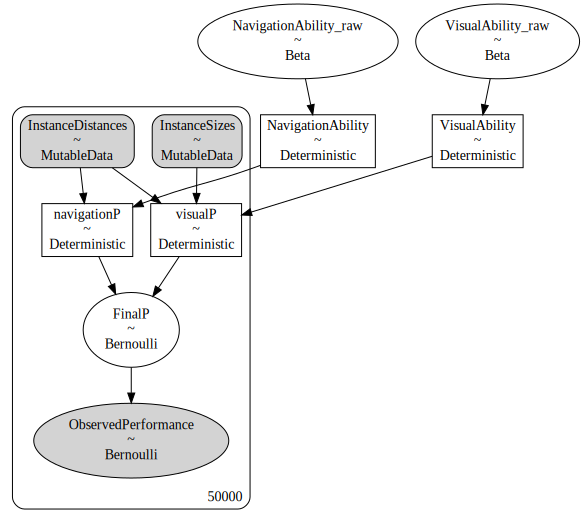

In [8]:
gv = pm.model_graph.model_to_graphviz(m)
gv

We can use PyMC's model_to_graphviz function to visualise what this probabilistic model looks like. In this diagram oval-shaped nodes are probability distributions, whereas rectangles are deterministic calculations. rounded rectangles are the MutableData class. Grey nodes are "observed".
The arrows determine a causal structure or the direction of flow of information. Within the measurement layouts framework these arrows designate the prescence of a linking function.

Note that our scaled-beta "NavigationAbility" is deterministic in this graph because of the way that the scaledbeta function is implemented. Where a deterministic function is applied to stretch out the result yielded from a 0-1 bounded "NavigationAbility_raw".





We can now perform the inference procedure on the model using the data. This follows the standard PyMC approach:

In [20]:
with m:
  inferenceData = pm.sample(1000)

With our model m, we let PyMC infer the most likely values for the capabilities that we have based on the meta-features and the agent's performance.

We can plot the distribution that we PyMC finds for the capability

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: title={'center': 'NavigationAbility'}>,
       <Axes: title={'center': 'VisualAbility'}>], dtype=object)

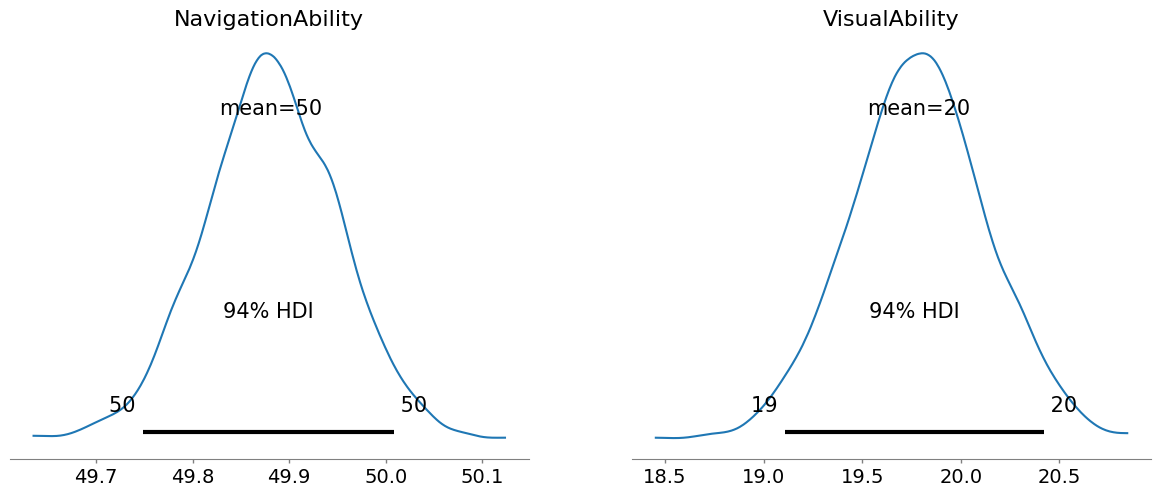

In [21]:
az.plot_posterior(inferenceData["posterior"][["NavigationAbility", "VisualAbility"]])


As we can see, PyMC has inferred that the agent's navigationAbility is centred around 50 and the visualAbility around 20.
But how do we know if these inferences are reasonable? In the next section we will explore this.




#Model Diagnostics
PyMC is powerful and intuitive enough that we can straightforwardly design measurement layouts. But how do we know if the data are appropriate for them, or whether there are any issues with how they were fitted? There are several diagnostics we can run on measurement layouts, of which some of the most useful are presented here.

First, we can look at the traces for each of the capabilities. Below, we can visualise the traces. For each chain (we have used 2 chains above), there is a posterior distribution (see the left plot). We want them to look relatively similar to each other, as this means that each chain converged to a similar posterior. On the right, we see a time series plot indicating how often each of the values were sampled in the chain. We want there to be relative homogeneity here, suggesting that all values were sampled a similar number of times. Note, depending on the prior, there might be spikes for certain values (if, for instance, the prior is a Cauchy distribution or something similarly heavy-tailed).

array([[<Axes: title={'center': 'NavigationAbility'}>,
        <Axes: title={'center': 'NavigationAbility'}>],
       [<Axes: title={'center': 'VisualAbility'}>,
        <Axes: title={'center': 'VisualAbility'}>]], dtype=object)

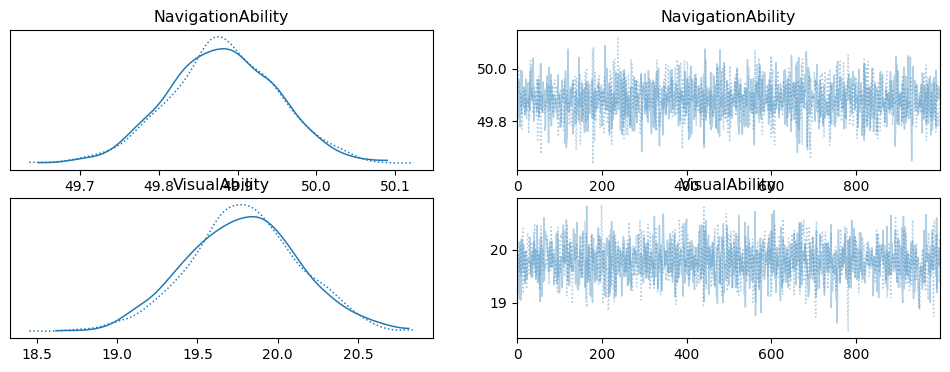

In [22]:
az.plot_trace(inferenceData["posterior"][["NavigationAbility","VisualAbility"]])

A second diagnostic is an energy plot, which also enables us to check whether the MCMC algorithm (usually, as here, NUTS) has explored the full posterior distribution. In the energy plot, we simply want the distribution of marginal energy during sampling, and distribution of energy transitions between steps (see [here](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html#model-checking) and [here](https://arxiv.org/abs/160400695), to overlap and look similar. Everything looks good for our agents with the simple measurement layout:

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


<Axes: >

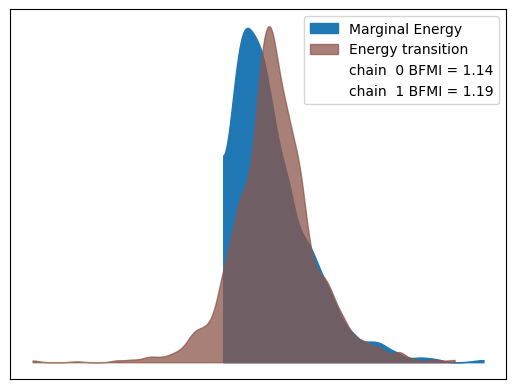

In [23]:
az.plot_energy(inferenceData)

In the literature on Bayesian statistics, several convergence diagnostics have been proposed. [Vehtari et al. (2021)](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-2/Rank-Normalization-Folding-and-Localization--An-Improved-R%cb%86-for/10.1214/20-BA1221.full) present a comprehensive overview. Two diagnostics that we can use out of the box to gauge the convergence of multiple chains when fitting a measurement layout are $\hat{R}$
 and Effective Sample Size (ESS).

 $\hat{R}$ is, roughly, the ratio of the variance mixed across all chains compared to the root mean squared variance of the variance in each individual chain. If the chains are not converging, then the between-chain variance should be higher than the within-chain variance, so values higher than 1 indicate lack of convergence. In practice, Vehtari et al. suggest values higher than 1.01 indicate a lack of convergence. Below, we present $\hat{R}$
 for both navigation and visual capabilities..

ESS is, roughly, "how many independent draws contain the same information as the dependent sample obtained by the MCMC algorithm. The higher the ESS the better" [(Vehtari et al., 2021, p. 672)](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-2/Rank-Normalization-Folding-and-Localization--An-Improved-R%cb%86-for/10.1214/20-BA1221.full). We can distinguish between $ESS_{bulk}$
 and $ESS_{tail}$
 too, where the latter is the ESS in the tails of the posterior distribution, outside of the credibility interval. This is especially useful if credibility intervals are to be used downstream in inference. Below, note that the sample size for each chain is 2000 (1000 warm up, 1000 sample; unless you have changed it).

In [24]:
az.summary(inferenceData["posterior"][["NavigationAbility","VisualAbility"]])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
NavigationAbility,49.881,0.069,49.748,50.009,0.002,0.001,2151.0,1539.0,1.0
VisualAbility,19.785,0.347,19.106,20.421,0.008,0.006,1918.0,1265.0,1.0


Another way that we can test the inferences of the measurement layout is by using it to predict overall performance on an unseen test set. This is similar in nature to the train-test split that is common in ML.

We have a test set prepared. Let's download it:

In [25]:
df_test = pd.read_csv("https://raw.githubusercontent.com/Kinds-of-Intelligence-CFI/measurement-layout-tutorial/main/data/visionNavigationMeasurementLayoutTestData.csv")

We will also need to define a function that will do the prediction for us. This will leverage PyMC's sample_posterior_predictive function.

In [26]:
def predict(m, trace, relevantData):
  with m:

    predictions = pm.sample_posterior_predictive(trace, var_names=["FinalP"], return_inferencedata=False,predictions=True,extend_inferencedata=False)
    predictionChainRuns = predictions["FinalP"][:,:,0:len(relevantData)]
    predictionsInstance = np.mean(predictionChainRuns, (0,1))

    return predictionsInstance


To use the predictions we create a new model with the test data in as meta-features. We then pass it to the predict function along with the learnt trace of the inferred data because this is where the distributions for each capability are kept.

In [27]:

m_test = setupModel(df_test)

predictions = predict(m_test, inferenceData, df_test)

Now that we have our predictions we want to evaluate how good they were on our test-set. As our model is predicting probabilities of success we can use the [Brier score](https://en.wikipedia.org/wiki/Brier_score) as a metric for understanding how good our model is at predicting performance.

The Brier score is defined as follows
$$Brier Score = \frac{1}{N} \sum_{i=1}^N(f_i - o_i)^2 $$

Where:
$N$ is the number of items in the test set. $f_i$ is the prediction made by the model for the $i$th element, and $o_i$ is the actual outcome for the $i$th element.

This is, at its core, the Mean Squared Error of the prediction model where we limit the outcomes to binary events.


To use the Brier score, let's define the function we need:

In [28]:
def brierDecomp(preds, outs):
    brier = 1 / len(preds) * sum((preds - outs) ** 2)
    bins = np.linspace(0, 1, 11)
    binCenters = (bins[:-1] + bins[1:]) / 2
    binPredInds = np.digitize(preds, binCenters)
    binnedPreds = bins[binPredInds]

    binTrueFreqs = np.zeros(10)
    binPredFreqs = np.zeros(10)
    binCounts = np.zeros(10)

    for i in range(10):
        idx = (preds >= bins[i]) & (preds < bins[i + 1])

        binTrueFreqs[i] = np.sum(outs[idx]) / np.sum(idx) if np.sum(idx) > 0 else 0

        binPredFreqs[i] = np.mean(preds[idx]) if np.sum(idx) > 0 else 0
        binCounts[i] = np.sum(idx)

    calibration = np.sum(binCounts * (binTrueFreqs - binPredFreqs) ** 2) / np.sum(binCounts) if np.sum(
        binCounts) > 0 else 0
    refinement = np.sum(binCounts * (binTrueFreqs * (1 - binTrueFreqs))) / np.sum(binCounts) if np.sum(
        binCounts) > 0 else 0

    return brier, calibration, refinement

This is a version of the Brier score that also breakds down the score into two components: calibration and refinement. These will become useful later on.

In [29]:
brierScore, calibration, refinement = brierDecomp(predictions, df_test["Success"])

In [31]:
brierScore

0.0793220371000734

Here we (hopefully!) see that the Brier Score is low. This corresponds to a good prediction.
But how good is this compared to what we could achieve with alternative methods?






# Comparison to XGBoost
Let's compare the predictive power of the measurement layouts to XGBoost.
First we will need to import the relevant libraries



In [32]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier

In [33]:
inputFeatures = ["Distance", "Size"]
outputFeature = "Success"

XTrain=df[inputFeatures]
yTrain=df[outputFeature]

XTest = df_test[inputFeatures]
yTest = df_test[outputFeature]

We assign the meta-features to input Features and the observed success as an output feature before collecting all of the examples in the training set together as XTrain and YTrain.

In [34]:
model = XGBClassifier(objective='binary:logistic')
# Set up KFold cross-validation

model.fit(XTrain, yTrain)
# Make predictions on the test data
yPredictions = model.predict_proba(XTest)[:, 1]  # Get the probabilities for the positive class
brierScoreXGBoost, calibrationXGBoost, refinementXGBoost = brierDecomp(yPredictions, yTest)


In [35]:
brierScoreXGBoost

0.0828323149356932

The Brier score achieved for XGBoost should be about the same as the one for the Measurement Layout.

This is a positive result! The measurement layouts allow for high predictive power while also providing *explanatory* power. We can extract capabilities to help us understand the direct limitations of AI systems (here we can identify *why* the agent is failing, navigation or vision. But we don't have to sacrifice predictive power to do so.

This concludes the first tutorial on using the Measurement Layouts. The next few tutorials will explore more complex tasks with bigger measurement layouts, as well as applying them to completely different domains.